<a href="https://colab.research.google.com/github/francescovenco000004/VAE-collection/blob/main/4_stable_beta_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
# Change to the project directory
project_path = "/content/drive/My Drive/beta-VAE/.3_new_data/model_directory"
os.chdir(project_path)

# Verify the current working directory

print("Current Working Directory: ", os.getcwd())
import sys

sys.path.append(project_path)

# Verify that the project path is in the Python path
print("Python Path: ", sys.path)

Mounted at /content/drive
Current Working Directory:  /content/drive/My Drive/beta-VAE/.3_new_data/model_directory
Python Path:  ['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/tmp/tmpe1tfj7um', '/content/drive/My Drive/beta-VAE/.3_new_data/model_directory']


# gradually increasing beta during training: beta-conditional-VAE.

hyper paramaters:

x shape: (17740,8)

conditions shape: (17740, 17)

hyperparamters:

hidden_dim1=64,

hidden_dim2=32,

z_dim=10

optimizer = Adam,

lr=1e-4

epochs=50

batch size = 128

beta increment = +0.02 per epoch

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assume df has been pre-processed and loaded
df = pd.read_csv("Variables Codebook and training data.xlsx - Sheet3.csv")
df = df.drop('Subject', axis=1)
df.drop('NoChoice', axis=1)



#drop empty 'choice' observations
df.dropna(subset=['Choices'], inplace=True)
print(df.shape)

#add avergae response times for missing values
#df['col_name'].fillna(value=8.398, inplace=True)
df.dropna(subset=['TimeNext'], inplace = True)
print(df.shape)

import numpy as np
# Check if there are any NaN values in the data
print(df.isnull().sum())  # This will show if any column has NaN values

# Alternatively, you can check if any values are infinite (infinite values could cause NaNs)
print((~np.isfinite(df)).sum())  # This checks for infinite values in the dataframe


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# Assuming df contains both lottery details and personal attributes
# Example: Lottery data (choices, time) in X_lottery, personal attributes in X_personal

# Separate into main input and condition variables
X_lottery = df[['REV{NoChoice}a','REV{NoChoice}b', 'Choices', 'RoundProbValue', 'TimeNext', 'TP','EvDiff', 'D_SetProminGain']].values
X_personal = df[['NoChoice', 'female', 'math', 'PointIQ', 'PointIE', 'SE', 'B5Extra','B5Agree', 'B5Consc', 'B5Emot', 'B5Open', 'violator', 'TPfirst','swiftness', 'IQfirst', 'TPmiss', 'NTPmiss']].values

# Scale/normalize both parts separately
scaler_lottery = StandardScaler()
X_lottery_scaled = scaler_lottery.fit_transform(X_lottery)

scaler_personal = StandardScaler()
X_personal_scaled = scaler_personal.fit_transform(X_personal)

# Convert to PyTorch tensors
X_lottery_tensor = torch.tensor(X_lottery_scaled, dtype=torch.float32)
X_personal_tensor = torch.tensor(X_personal_scaled, dtype=torch.float32)

# Concatenate the tensors for training
train_lottery, val_lottery, train_personal, val_personal = train_test_split(
    X_lottery_tensor, X_personal_tensor, test_size=0.2, random_state=42
)

# Create a new dataset with both inputs
train_dataset = TensorDataset(train_lottery, train_personal)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(val_lottery, val_personal)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torch.optim import Adam

# Define Encoder, Decoder, and ConditionalVAE classes
class Encoder(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim1, hidden_dim2, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim + cond_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, z_dim)

    def forward(self, x, cond):
        x_cond = torch.cat([x, cond], dim=-1)
        h1 = F.relu(self.fc1(x_cond))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim, cond_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim + cond_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, z, cond):
        z_cond = torch.cat([z, cond], dim=-1)
        h = F.relu(self.fc1(z_cond))
        h = F.relu(self.fc2(h))
        x_recon = self.fc3(h)
        return x_recon

class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim1, hidden_dim2, z_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(input_dim, cond_dim, hidden_dim1, hidden_dim2, z_dim)
        self.decoder = Decoder(z_dim, cond_dim, hidden_dim1, hidden_dim2, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, cond):
        mu, logvar = self.encoder(x, cond)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, cond)
        return x_recon, mu, logvar

    def loss_function(self, x, x_recon, mu, logvar, beta=1.0):
        # Reconstruction loss
        recon_loss = F.mse_loss(x_recon, x, reduction='mean')
        # KL divergence with beta factor
        kl_div = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_div



In [ ]:

import torch
from torch.cuda.amp import GradScaler
from torch.optim import Adam

# Set up the model, optimizer, and scaler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)  # Xavier initialization for weights
        if m.bias is not None:
            m.bias.data.fill_(0.01)  # Initialize biases to small values


# Set up the model
cond_dim = train_personal.shape[1]  # The dimension of the conditional variables (e.g., IQ, personality traits)
model = ConditionalVAE(input_dim=train_lottery.shape[1], cond_dim=cond_dim, hidden_dim1=64, hidden_dim2=32, z_dim=5).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()


model.apply(init_weights)

# Training Loop
num_epochs = 50
save_path = './conditional_vae_model.pth'


# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cond_dim = train_personal.shape[1]
model = ConditionalVAE(input_dim=train_lottery.shape[1], cond_dim=cond_dim, hidden_dim1=64, hidden_dim2=32, z_dim=5).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()


num_epochs = 50
save_path = './beta_conditional_vae_model.pth'
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    # Linearly scale beta from 1.0 to 2.0 over the epochs
    beta = 1 + (epoch / num_epochs)

    for batch_idx, (lottery_data, personal_data) in enumerate(train_loader):
        lottery_data, personal_data = lottery_data.to(device), personal_data.to(device)
        optimizer.zero_grad()

        # Forward pass
        with torch.cuda.amp.autocast():
            x_recon, mu, logvar = model(lottery_data, personal_data)
            loss = model.loss_function(lottery_data, x_recon, mu, logvar, beta=beta)

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Beta: {beta:.4f}')


In [ ]:
model.eval()  # Set the model to evaluation mode
val_loss = 0
with torch.no_grad():  # Disable gradient calculation for testing
    for batch_idx, (lottery_data, personal_data) in enumerate(val_loader):  # Loop through validation data
        lottery_data = lottery_data.to(device)
        personal_data = personal_data.to(device)

        # Forward pass through the model with both inputs and conditional variables
        x_recon, mu, logvar = model(lottery_data, personal_data)

        # Calculate the loss (reconstruction + KL divergence)
        loss = model.loss_function(lottery_data, x_recon, mu, logvar)

        # Accumulate the validation loss
        val_loss += loss.item()

# Calculate average validation loss
avg_val_loss = val_loss / len(val_loader.dataset)
print(f'Validation Loss: {avg_val_loss:.4f}')


# gradually increasing beta during training: beta-VAE (non-conditional).

hyper paramaters:

x shape: (17740,8)

conditions shape: (17740, 17)

hyperparamters:

hidden_dim1=64,

hidden_dim2=32,

z_dim=10

optimizer = Adam,

lr=1e-4

epochs=50

batch size = 128

beta increment = +0.02 per epoch

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assume df has been pre-processed and loaded
df = pd.read_csv("Variables Codebook and training data.xlsx - Sheet3.csv")
df = df.drop('Subject', axis=1)
df.drop('NoChoice', axis=1)



#drop empty 'choice' observations
df.dropna(subset=['Choices'], inplace=True)
print(df.shape)

#add avergae response times for missing values
#df['col_name'].fillna(value=8.398, inplace=True)
df.dropna(subset=['TimeNext'], inplace = True)
print(df.shape)



# Scale/normalize the trial and participant features
scaler_trial = StandardScaler()
X = scaler_trial.fit_transform(df)


# Convert the NumPy array to PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)

# Optionally split the data into train and validation sets
X_train, X_val = train_test_split(X_tensor, test_size=0.2, random_state=42)

# Create PyTorch Dataset and DataLoader
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)


val_dataset = TensorDataset(X_val)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)


(17926, 25)
(17740, 25)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torch.optim import Adam

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, z_dim)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim=32, output_dim=1, dropout_rate=0.2):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = self.dropout(h)  # Apply dropout after the hidden layer
        x_recon = self.fc2(h)
        return x_recon

class BetaVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, z_dim):
        super(BetaVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim1, hidden_dim2, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim=32, output_dim=input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

    def loss_function(self, x, x_recon, mu, logvar, beta=0.4):
        recon_loss = F.mse_loss(x_recon, x, reduction='mean')
        kl_div = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_div




In [ ]:
# Set up the model, optimizer, and scaler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

# Initialize the model with specified hidden layers and dropout
model = BetaVAE(input_dim=X_train.shape[1], hidden_dim1=64, hidden_dim2=32, z_dim=8).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()
model.apply(init_weights)

# Training Loop
num_epochs = 40
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    beta = 0.4  # Fixed beta
    for batch_idx, (data,) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            x_recon, mu, logvar = model(data)
            loss = model.loss_function(data, x_recon, mu, logvar, beta=beta)

        # Backward pass with mixed precision scaling
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Beta: {beta:.4f}')


<ipython-input-16-dfdc1a4526aa>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-16-dfdc1a4526aa>:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/40], Loss: 0.3383, Beta: 0.4000
Epoch [2/40], Loss: 0.1236, Beta: 0.4000
Epoch [3/40], Loss: 0.0475, Beta: 0.4000
Epoch [4/40], Loss: 0.0193, Beta: 0.4000
Epoch [5/40], Loss: 0.0104, Beta: 0.4000
Epoch [6/40], Loss: 0.0084, Beta: 0.4000
Epoch [7/40], Loss: 0.0080, Beta: 0.4000
Epoch [8/40], Loss: 0.0079, Beta: 0.4000
Epoch [9/40], Loss: 0.0079, Beta: 0.4000
Epoch [10/40], Loss: 0.0079, Beta: 0.4000
Epoch [11/40], Loss: 0.0079, Beta: 0.4000
Epoch [12/40], Loss: 0.0078, Beta: 0.4000
Epoch [13/40], Loss: 0.0078, Beta: 0.4000
Epoch [14/40], Loss: 0.0078, Beta: 0.4000
Epoch [15/40], Loss: 0.0078, Beta: 0.4000
Epoch [16/40], Loss: 0.0078, Beta: 0.4000
Epoch [17/40], Loss: 0.0078, Beta: 0.4000
Epoch [18/40], Loss: 0.0078, Beta: 0.4000
Epoch [19/40], Loss: 0.0078, Beta: 0.4000
Epoch [20/40], Loss: 0.0078, Beta: 0.4000
Epoch [21/40], Loss: 0.0078, Beta: 0.4000
Epoch [22/40], Loss: 0.0078, Beta: 0.4000
Epoch [23/40], Loss: 0.0078, Beta: 0.4000
Epoch [24/40], Loss: 0.0078, Beta: 0.4000
E

In [ ]:
model.eval()  # Set the model to evaluation mode
val_loss = 0
with torch.no_grad():  # Disable gradient calculation for testing
    for batch_idx, (data,) in enumerate(val_loader):  # Loop through validation data
        data = data.to(device)

        # Forward pass through the model
        x_recon, mu, logvar = model(data)

        # Calculate the loss (reconstruction + KL divergence)
        loss = model.loss_function(data, x_recon, mu, logvar)

        # Accumulate the validation loss
        val_loss += loss.item()

# Calculate average validation loss
avg_val_loss = val_loss / len(val_loader.dataset)
print(f'Validation Loss: {avg_val_loss:.4f}')


Validation Loss: 0.0081


In [ ]:
# Save the entire model
torch.save(model, './4.stable_beta_vae_entire_model.pth')

# Analysis: 1. Correlation heatmap

show surface level, linear relationship between x and z variables

In [ ]:
import torch

# Define your BetaVAE class (if not already defined)
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, z_dim)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        x_recon = self.fc3(h)
        return x_recon

class BetaVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, z_dim):
        super(BetaVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim1, hidden_dim2, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim1, hidden_dim2, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

    def loss_function(self, x, x_recon, mu, logvar, beta=1.0):
        recon_loss = F.mse_loss(x_recon, x, reduction='mean')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + beta * kl_div

# Load the entire model
model_path = './4.stable_beta_vae_entire_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model = torch.load(model_path, map_location=device)

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")


Model loaded successfully!


<ipython-input-20-7d60c59a57fb>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


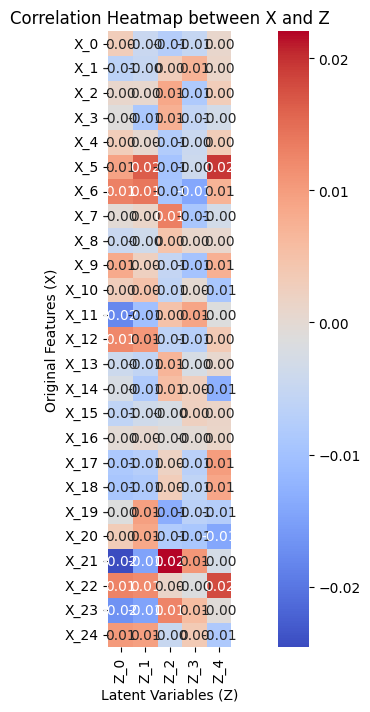

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set model to evaluation mode
model.eval()

# Assuming `X_tensor` is your full input dataset as a PyTorch tensor
# Move the dataset to the appropriate device
X_tensor = X_tensor.to(device)

# Get latent representations (mu and logvar) from the encoder
with torch.no_grad():
    mu, logvar = model.encoder(X_tensor)  # Only get mu (latent representation)

# Convert to NumPy for easier manipulation
X_numpy = X_tensor.cpu().numpy()  # Original input features
Z_numpy = mu.cpu().numpy()         # Latent representation

# Convert to pandas DataFrames
X_df = pd.DataFrame(X_numpy, columns=[f"X_{i}" for i in range(X_numpy.shape[1])])
Z_df = pd.DataFrame(Z_numpy, columns=[f"Z_{i}" for i in range(Z_numpy.shape[1])])

# Concatenate X and Z for direct correlation analysis
combined_df = pd.concat([X_df, Z_df], axis=1)

# Compute the correlation matrix
correlation_matrix = combined_df.corr()

# Extract only the correlations between X and Z
correlation_matrix_xz = correlation_matrix.iloc[:X_df.shape[1], X_df.shape[1]:]

# Visualize the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_xz, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title("Correlation Heatmap between X and Z")
plt.xlabel('Latent Variables (Z)')
plt.ylabel('Original Features (X)')
plt.show()


Index(['NoChoice', 'female', 'math', 'PointIQ', 'PointIE', 'SE', 'B5Extra',
       'B5Agree', 'B5Consc', 'B5Emot', 'B5Open', 'violator', 'TPfirst',
       'swiftness', 'IQfirst', 'TPmiss', 'NTPmiss', 'REV{NoChoice}a',
       'REV{NoChoice}b', 'Choices', 'RoundProbValue', 'TimeNext', 'TP',
       'EvDiff', 'D_SetProminGain'],
      dtype='object')

#  Analysis: 2. Latent space traversal

show non-linear partial derivative relationship between z and x variables, no combinations

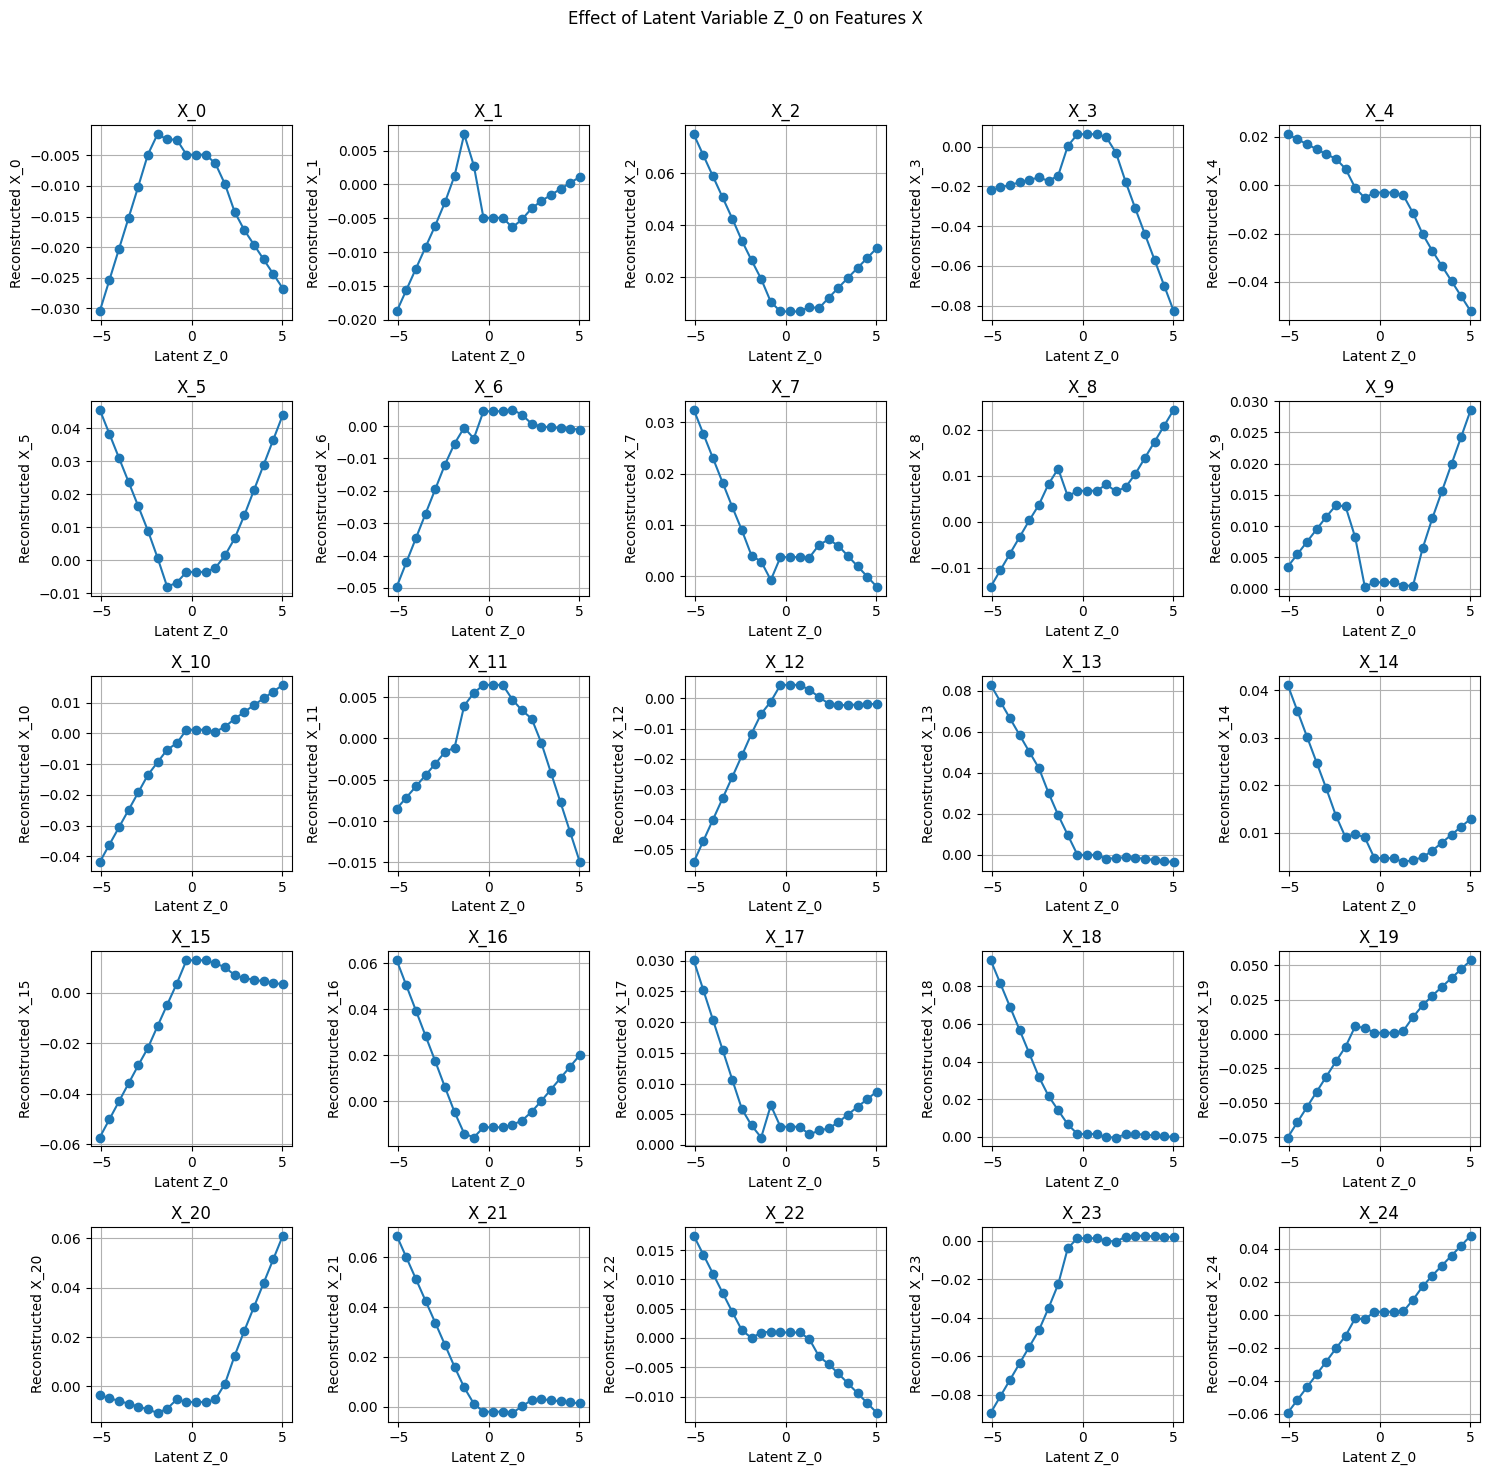

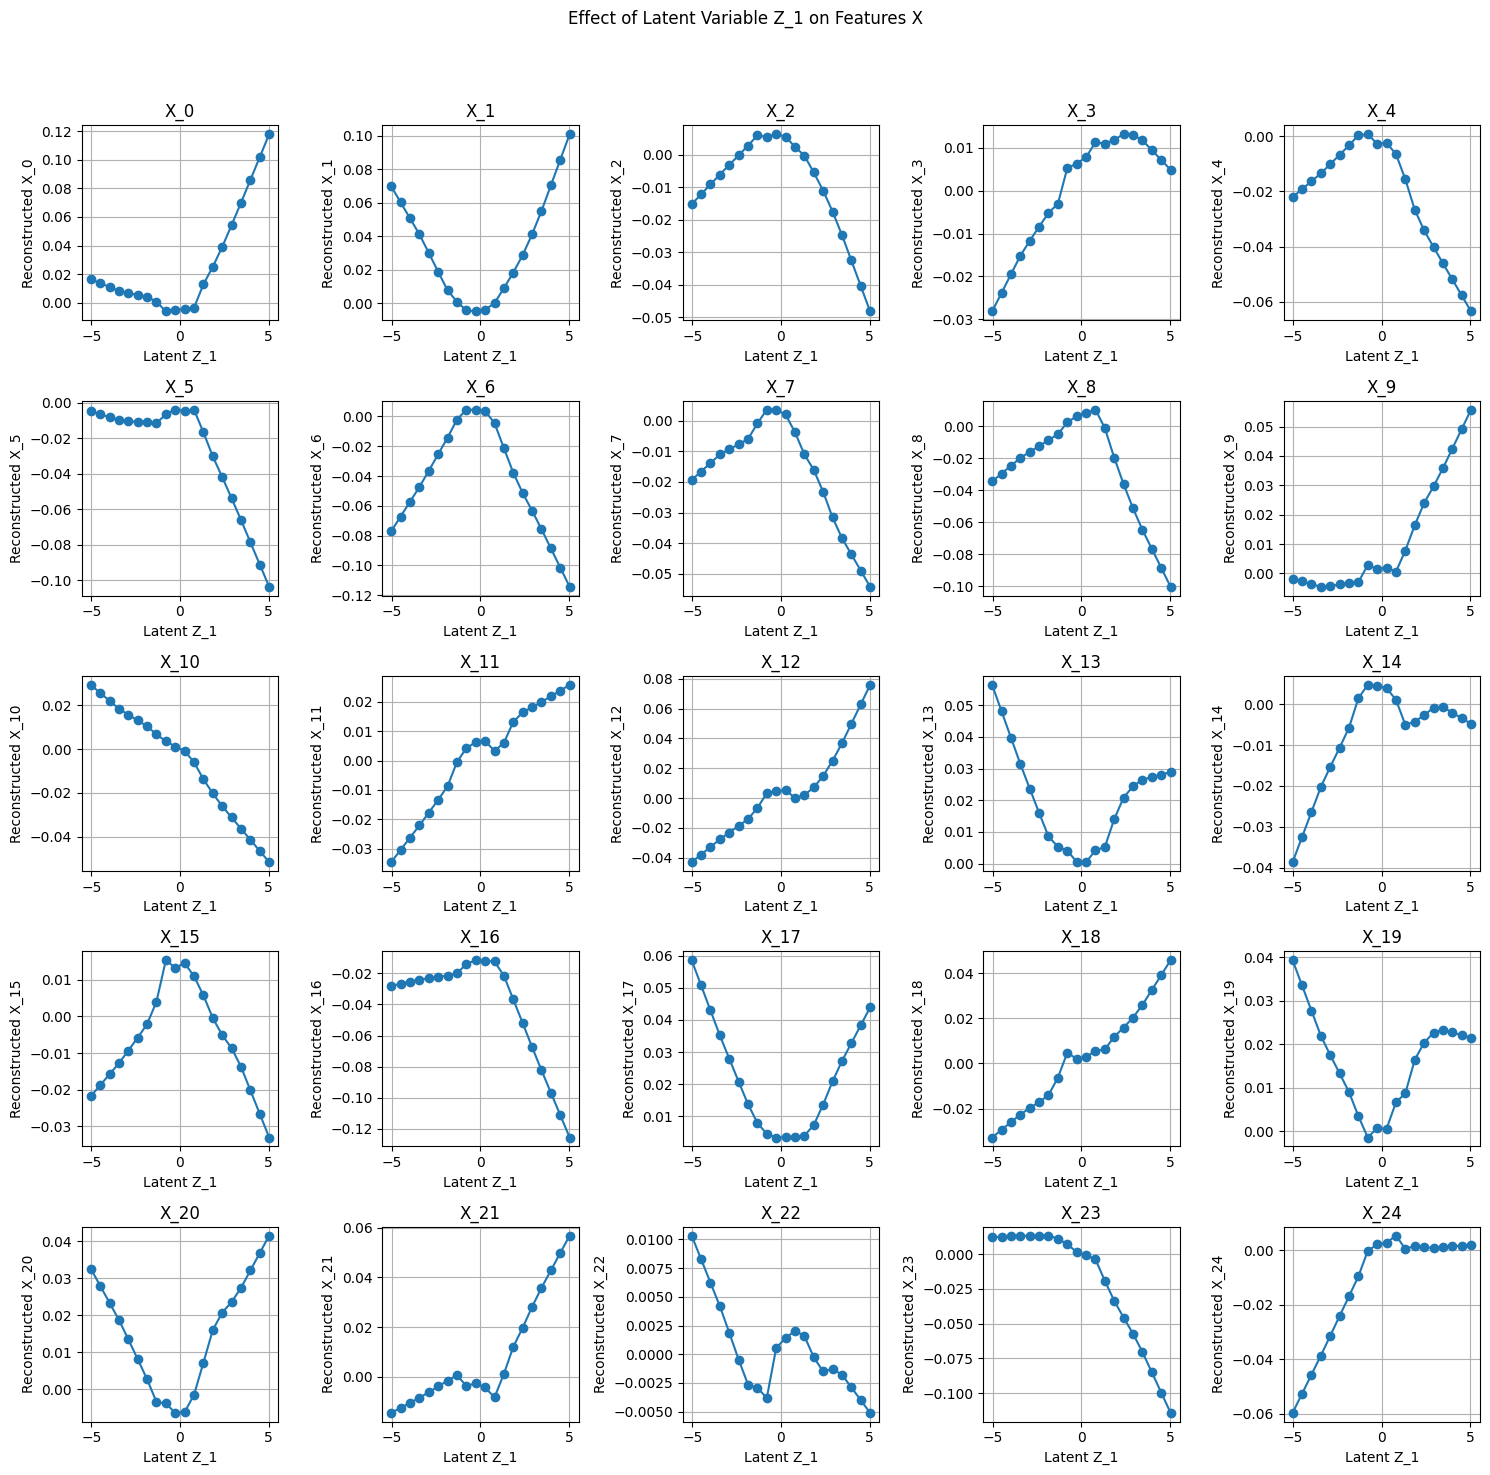

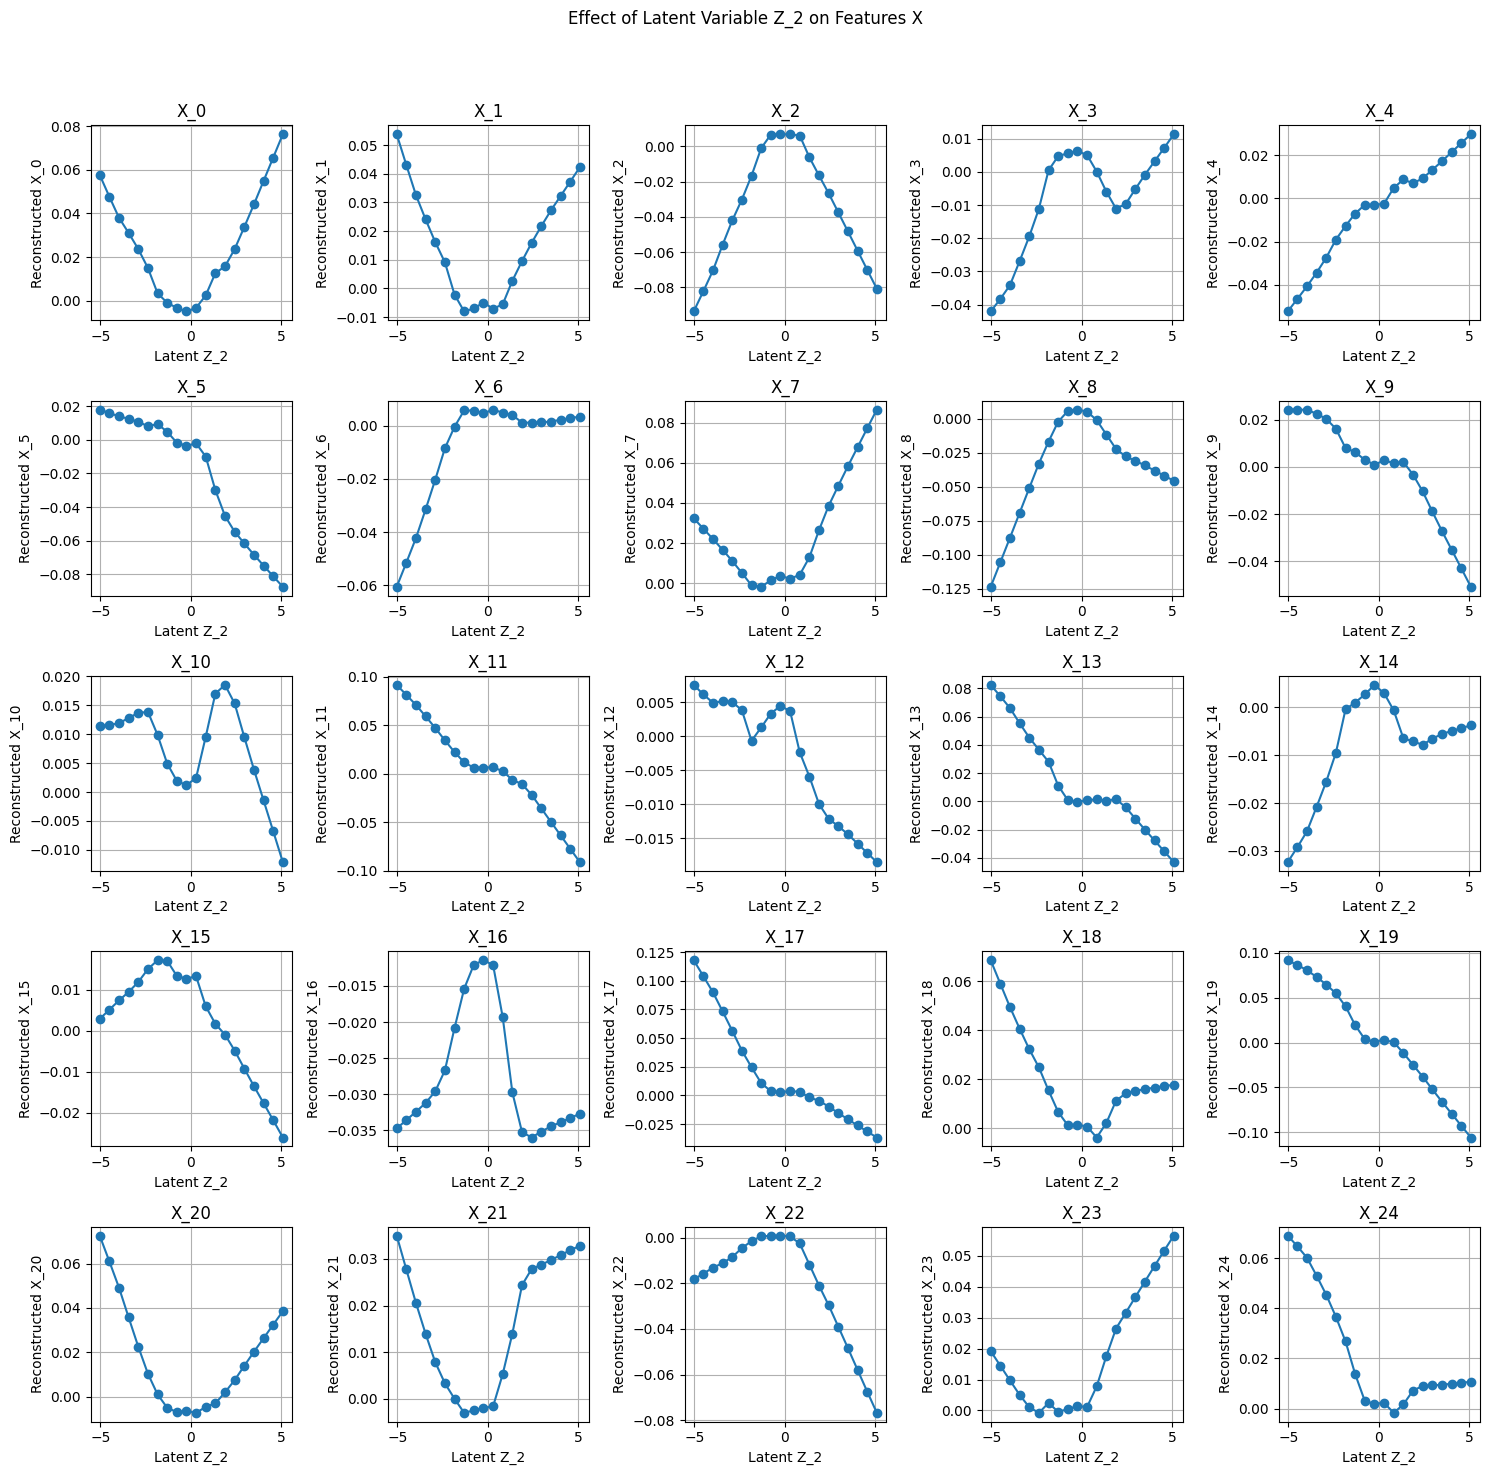

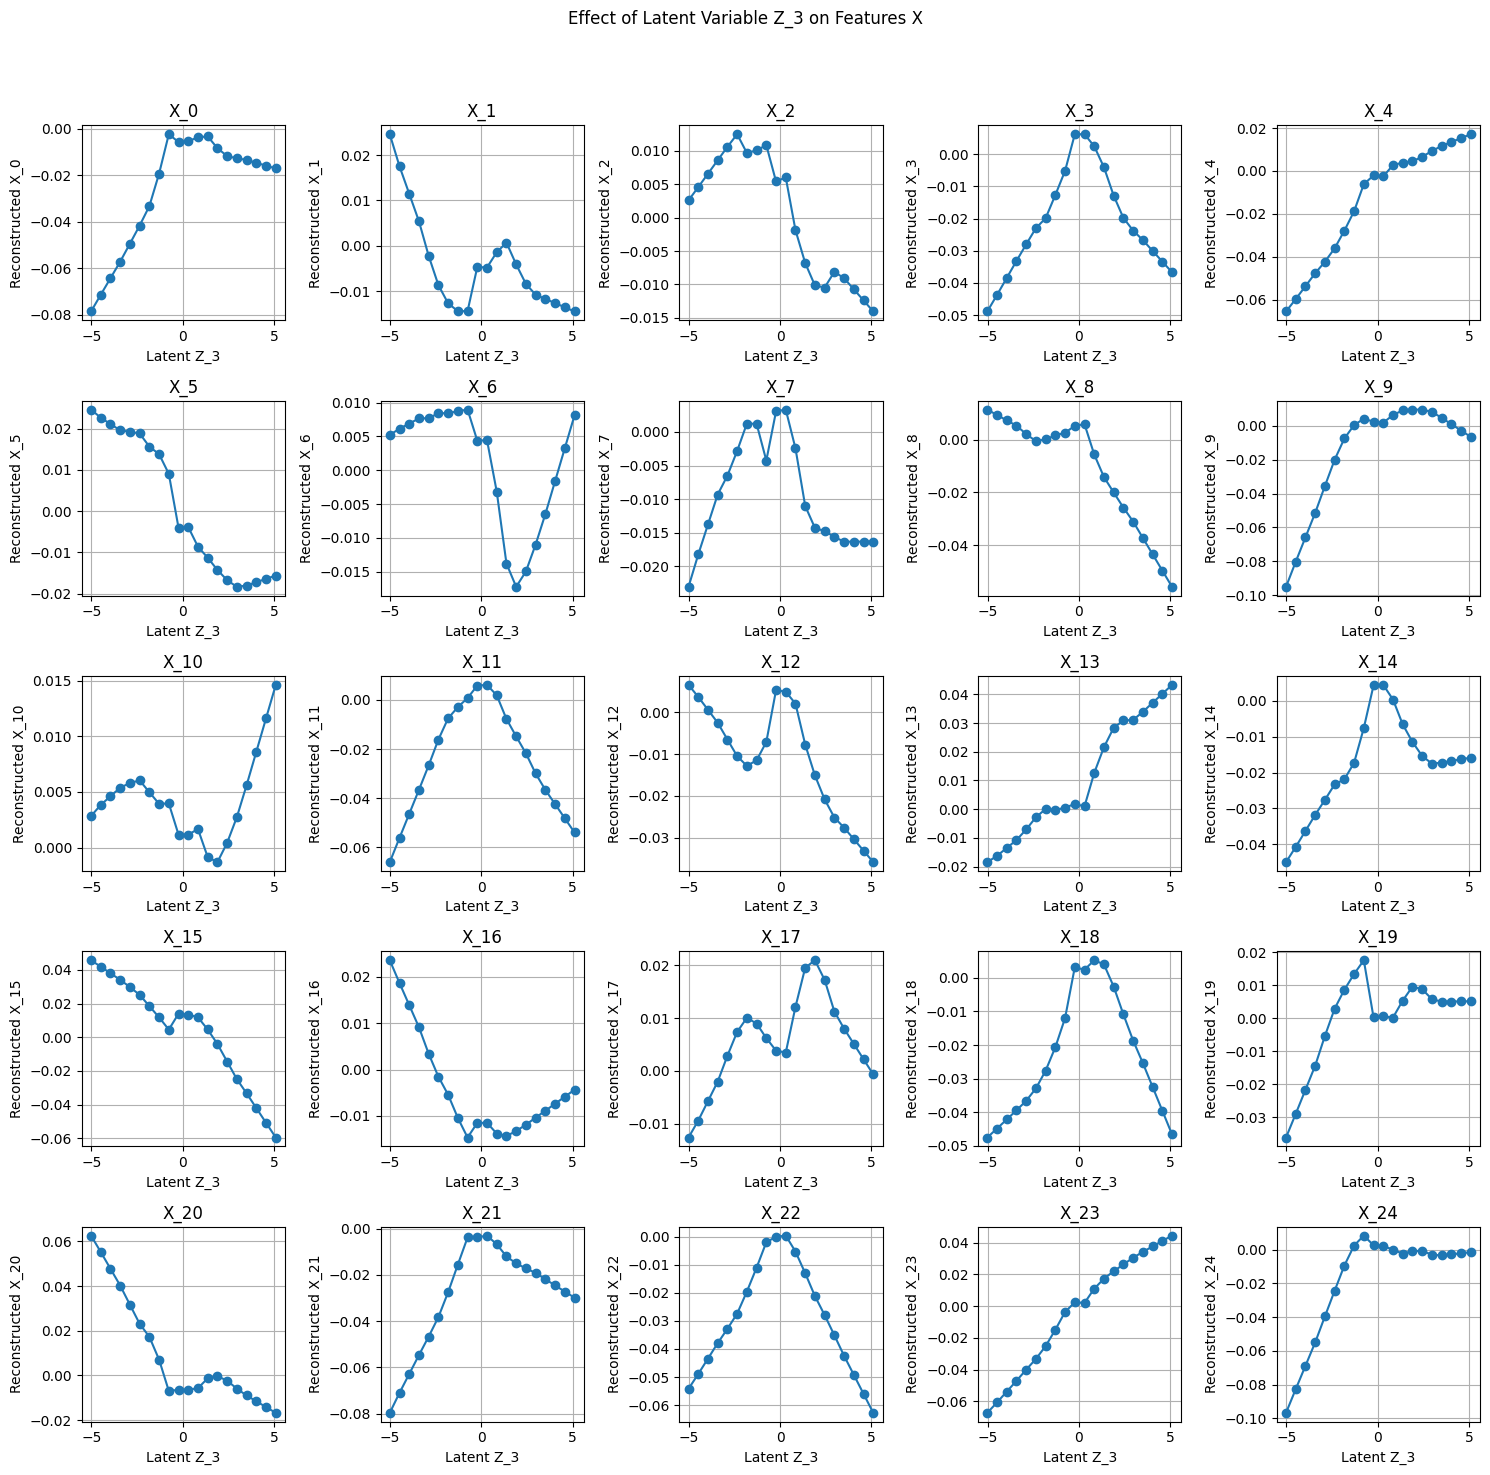

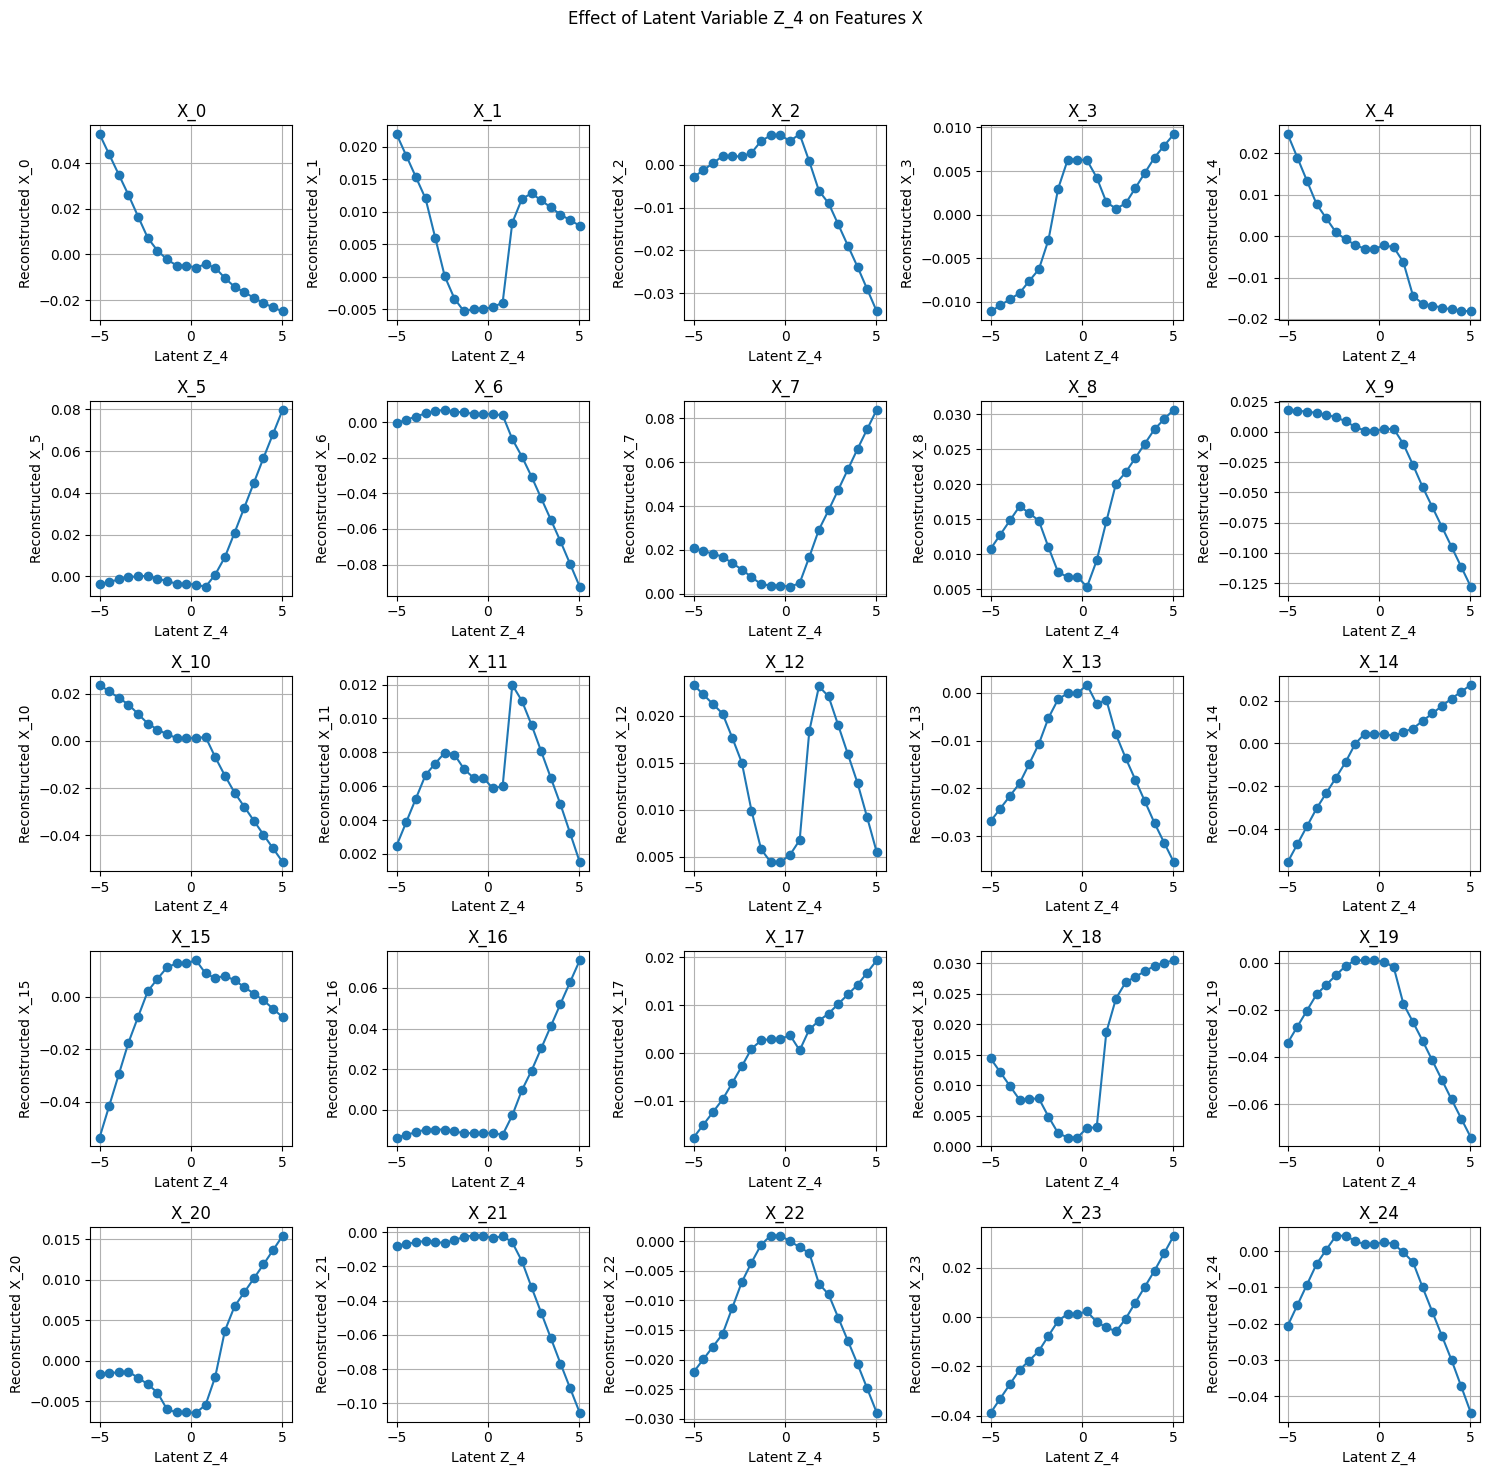

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Assuming z is your latent representation (e.g., mu from encoder)
# and model is your trained Beta-VAE model

# Determine the bounds for each latent variable
z_min = z.min(axis=0)-5
z_max = z.max(axis=0)+5

# Number of points for traversal
num_points = 20
features_per_row = 5  # Limit to 5 features per row

# Loop through each latent dimension
for i in range(z.shape[1]):  # Iterate over each latent dimension
    # Create the traversal range based on the min and max of the i-th latent variable
    traversal_range = np.linspace(z_min[i], z_max[i], num_points)  # 20 points between min and max

    # Create a copy of the latent representation with fixed values
    z_traversal = z.mean(axis=0, keepdims=True).repeat(len(traversal_range), axis=0)
    z_traversal[:, i] = traversal_range  # Vary only the i-th latent variable

    # Decode to observe changes in x
    x_recon = model.decoder(torch.tensor(z_traversal, dtype=torch.float32).to(device))

    # Convert the reconstructed data to numpy for visualization
    x_recon_np = x_recon.cpu().detach().numpy()

    # Determine the number of rows needed for each latent variable based on feature count
    num_features = x_recon_np.shape[1]
    num_rows = (num_features + features_per_row - 1) // features_per_row  # Ceiling division

    # Create figure for current latent variable
    fig, axes = plt.subplots(num_rows, features_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle(f"Effect of Latent Variable Z_{i} on Features X")

    # Plot the results for this latent variable in chunks of 5 features per row
    for j in range(num_features):
        row = j // features_per_row
        col = j % features_per_row
        ax = axes[row, col] if num_rows > 1 else axes[col]  # Adjust for single-row case

        ax.plot(traversal_range, x_recon_np[:, j], marker='o')
        ax.set_title(f'X_{j}')
        ax.set_xlabel(f'Latent Z_{i}')
        ax.set_ylabel(f'Reconstructed X_{j}')
        ax.grid()

    # Turn off unused axes if num_features is not a multiple of features_per_row
    for j in range(num_features, num_rows * features_per_row):
        row = j // features_per_row
        col = j % features_per_row
        if num_rows > 1:
            axes[row, col].axis('off')
        else:
            axes[col].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout and leave space for suptitle
    plt.show()


In [ ]:
# Assuming `X_tensor` is your full input dataset as a PyTorch tensor
# Move the dataset to the appropriate device
X_tensor = X_tensor.to(device)

# Get latent representations (mu and logvar) from the encoder
with torch.no_grad():
    mu, logvar = model.encoder(X_tensor)  # Only get mu (latent representation)

# Convert to NumPy for easier manipulation
X_numpy = X_tensor.cpu().numpy()  # Original input features
Z_numpy = mu.cpu().numpy()         # Latent representation

Summary Statistics for Latent Variables:
Latent Variable Z_0: Mean = -0.0000, Std Dev = 0.0003
Latent Variable Z_1: Mean = -0.0000, Std Dev = 0.0005
Latent Variable Z_2: Mean = -0.0000, Std Dev = 0.0005
Latent Variable Z_3: Mean = -0.0000, Std Dev = 0.0005
Latent Variable Z_4: Mean = -0.0000, Std Dev = 0.0004
Latent Variable Z_5: Mean = -0.0000, Std Dev = 0.0005
Latent Variable Z_6: Mean = -0.0000, Std Dev = 0.0005
Latent Variable Z_7: Mean = 0.0000, Std Dev = 0.0006


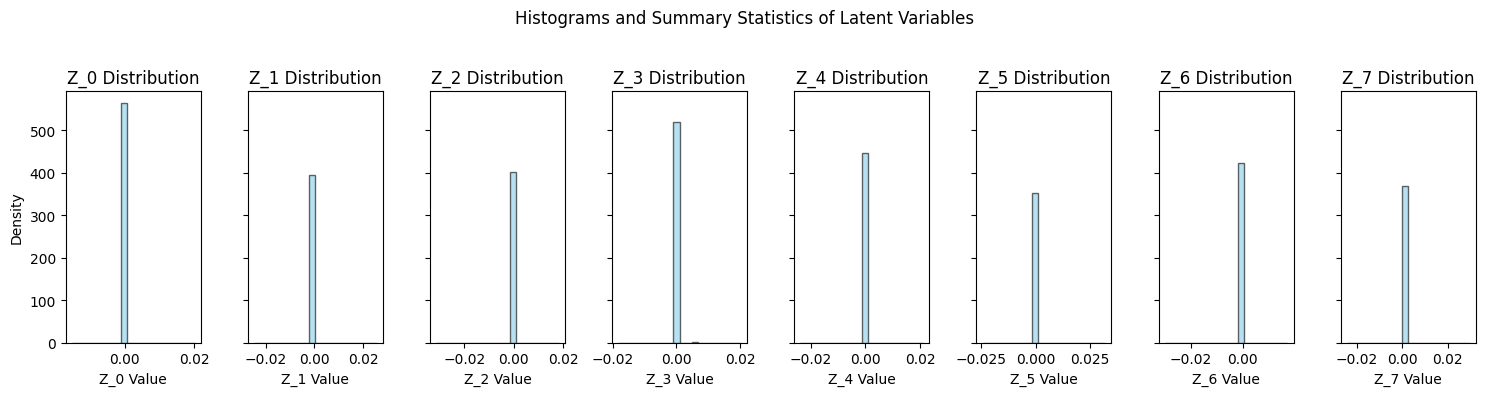

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming `z` is the latent representation (e.g., `mu` from the encoder) for all `X_tensor` data

# Convert `z` to a numpy array for easier manipulation if it’s not already
# z_numpy = z.cpu().numpy() if isinstance(z, torch.Tensor) else z

# Calculate summary statistics
means = np.mean(Z_numpy, axis=0)
std_devs = np.std(Z_numpy, axis=0)

# Print the summary statistics
print("Summary Statistics for Latent Variables:")
for i in range(Z_numpy.shape[1]):
    print(f"Latent Variable Z_{i}: Mean = {means[i]:.4f}, Std Dev = {std_devs[i]:.4f}")

# Plot histograms for each latent variable
num_latent_vars = Z_numpy.shape[1]
fig, axes = plt.subplots(1, num_latent_vars, figsize=(15, 4), sharey=True)

for i in range(num_latent_vars):
    ax = axes[i]
    ax.hist((Z_numpy)[:, i], bins=20, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    ax.set_title(f"Z_{i} Distribution")
    ax.set_xlabel(f"Z_{i} Value")
    ax.set_ylabel("Density" if i == 0 else "")  # Add y-label only to the first plot for clarity

plt.suptitle("Histograms and Summary Statistics of Latent Variables")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


model collapse: https://drpress.org/ojs/index.php/HSET/article/view/9995
https://aclanthology.org/2024.lrec-main.1250.pdf

# Scale VAE

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assume df has been pre-processed and loaded
df = pd.read_csv("Variables Codebook and training data.xlsx - Sheet3.csv")
df = df.drop('Subject', axis=1)
df.drop('NoChoice', axis=1)



#drop empty 'choice' observations
df.dropna(subset=['Choices'], inplace=True)
print(df.shape)

#add avergae response times for missing values
#df['col_name'].fillna(value=8.398, inplace=True)
df.dropna(subset=['TimeNext'], inplace = True)
print(df.shape)



# Scale/normalize the trial and participant features
scaler_trial = StandardScaler()
X = scaler_trial.fit_transform(df)


# Convert the NumPy array to PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)

# Optionally split the data into train and validation sets
X_train, X_val = train_test_split(X_tensor, test_size=0.2, random_state=42)

# Create PyTorch Dataset and DataLoader
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)


val_dataset = TensorDataset(X_val)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)


(17926, 25)
(17740, 25)


In [ ]:
class ScaleVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, z_dim, desired_std=2.0, f_epo=10):
        super(ScaleVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim1, hidden_dim2, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim=32, output_dim=input_dim)
        self.desired_std = desired_std
        self.f_epo = f_epo
        self.scaling_factors = None  # Placeholder for the average scaling factor

    def compute_scaling_factors(self, mu):
        # Calculate the standard deviation with a lower bound
        std_mu = torch.std(mu, dim=0).clamp(min=0.5)  # Clamp to avoid division by very small numbers
        scaling_factors = self.desired_std / std_mu
        return scaling_factors


    def reparameterize(self, mu, logvar, scaling_factors):
        # Apply the scaling factor to mu
        scaled_mu = mu * scaling_factors
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return scaled_mu + eps * std

    def forward(self, x, epoch):
        mu, logvar = self.encoder(x)

        # During the first f_epo epochs, calculate scaling factors for each batch
        if epoch < self.f_epo:
            scaling_factors = self.compute_scaling_factors(mu)
            # Aggregate scaling factors across batches for averaging later
            if self.scaling_factors is None:
                self.scaling_factors = scaling_factors.clone().detach()
            else:
                self.scaling_factors += scaling_factors.clone().detach()
        else:
            # After f_epo epochs, use the averaged scaling factor across batches
            if epoch == self.f_epo:  # Compute average only once after f_epo epochs
                self.scaling_factors /= (epoch * len(train_loader))  # Average over batches
            scaling_factors = self.scaling_factors

        z = self.reparameterize(mu, logvar, scaling_factors)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

    def loss_function(self, x, x_recon, mu, logvar, beta=1.0):
        # Reconstruction loss (mean squared error)
        recon_loss = F.mse_loss(x_recon, x, reduction='mean')
        # KL divergence term using the original mu and logvar
        kl_div = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_div


In [ ]:
# Set up the model, optimizer, and scaler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

# Initialize the model with specified hidden layers and dropout
model = ScaleVAE(input_dim=X_train.shape[1], hidden_dim1=64, hidden_dim2=32, z_dim=8, desired_std=1.0, f_epo=10).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()
model.apply(init_weights)

# Training Loop
num_epochs = 40
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    beta = 1.0  # Fixed beta
    for batch_idx, (data,) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            x_recon, mu, logvar = model(data, epoch)
            loss = model.loss_function(data, x_recon, mu, logvar, beta=beta)

        # Backward pass with mixed precision scaling
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Beta: {beta:.4f}')


<ipython-input-14-174a9f9b8554>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-14-174a9f9b8554>:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/40], Loss: 1.0367, Beta: 1.0000
Epoch [2/40], Loss: 0.3291, Beta: 1.0000
Epoch [3/40], Loss: 0.1061, Beta: 1.0000
Epoch [4/40], Loss: 0.0306, Beta: 1.0000
Epoch [5/40], Loss: 0.0117, Beta: 1.0000
Epoch [6/40], Loss: 0.0087, Beta: 1.0000
Epoch [7/40], Loss: 0.0083, Beta: 1.0000
Epoch [8/40], Loss: 0.0078, Beta: 1.0000
Epoch [9/40], Loss: 0.0075, Beta: 1.0000
Epoch [10/40], Loss: 0.0074, Beta: 1.0000
Epoch [11/40], Loss: 0.0074, Beta: 1.0000
Epoch [12/40], Loss: 0.0074, Beta: 1.0000
Epoch [13/40], Loss: 0.0073, Beta: 1.0000
Epoch [14/40], Loss: 0.0073, Beta: 1.0000
Epoch [15/40], Loss: 0.0074, Beta: 1.0000
Epoch [16/40], Loss: 0.0074, Beta: 1.0000
Epoch [17/40], Loss: 0.0074, Beta: 1.0000
Epoch [18/40], Loss: 0.0074, Beta: 1.0000
Epoch [19/40], Loss: 0.0073, Beta: 1.0000
Epoch [20/40], Loss: 0.0072, Beta: 1.0000
Epoch [21/40], Loss: 0.0072, Beta: 1.0000
Epoch [22/40], Loss: 0.0072, Beta: 1.0000
Epoch [23/40], Loss: 0.0073, Beta: 1.0000
Epoch [24/40], Loss: 0.0073, Beta: 1.0000
E

In [ ]:
# Assuming `X_tensor` is your full input dataset as a PyTorch tensor
# Move the dataset to the appropriate device
X_tensor = X_tensor.to(device)

# Get latent representations (mu and logvar) from the encoder
with torch.no_grad():
    mu, logvar = model.encoder(X_tensor)  # Only get mu (latent representation)

# Convert to NumPy for easier manipulation
X_numpy = X_tensor.cpu().numpy()  # Original input features
Z_numpy = mu.cpu().numpy()         # Latent representation

Summary Statistics for Latent Variables:
Latent Variable Z_0: Mean = 0.0000, Std Dev = 0.0003
Latent Variable Z_1: Mean = -0.0000, Std Dev = 0.0004
Latent Variable Z_2: Mean = -0.0000, Std Dev = 0.0005
Latent Variable Z_3: Mean = 0.0000, Std Dev = 0.0005
Latent Variable Z_4: Mean = -0.0000, Std Dev = 0.0005
Latent Variable Z_5: Mean = 0.0000, Std Dev = 0.0004
Latent Variable Z_6: Mean = 0.0000, Std Dev = 0.0004
Latent Variable Z_7: Mean = 0.0000, Std Dev = 0.0003


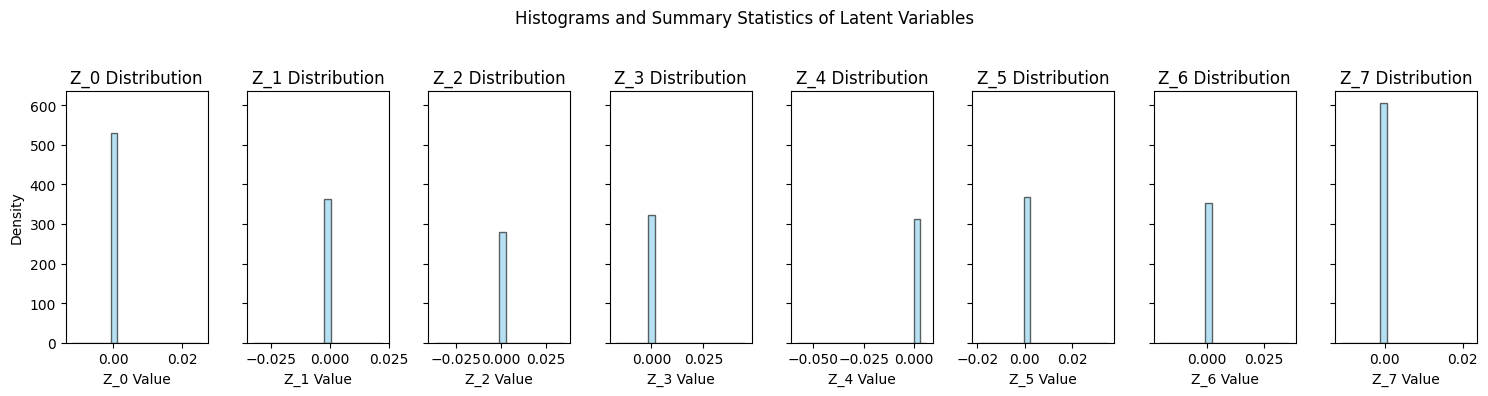

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming `z` is the latent representation (e.g., `mu` from the encoder) for all `X_tensor` data

# Convert `z` to a numpy array for easier manipulation if it’s not already
# z_numpy = z.cpu().numpy() if isinstance(z, torch.Tensor) else z

# Calculate summary statistics
means = np.mean(Z_numpy, axis=0)
std_devs = np.std(Z_numpy, axis=0)

# Print the summary statistics
print("Summary Statistics for Latent Variables:")
for i in range(Z_numpy.shape[1]):
    print(f"Latent Variable Z_{i}: Mean = {means[i]:.4f}, Std Dev = {std_devs[i]:.4f}")

# Plot histograms for each latent variable
num_latent_vars = Z_numpy.shape[1]
fig, axes = plt.subplots(1, num_latent_vars, figsize=(15, 4), sharey=True)

for i in range(num_latent_vars):
    ax = axes[i]
    ax.hist((Z_numpy)[:, i], bins=20, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    ax.set_title(f"Z_{i} Distribution")
    ax.set_xlabel(f"Z_{i} Value")
    ax.set_ylabel("Density" if i == 0 else "")  # Add y-label only to the first plot for clarity

plt.suptitle("Histograms and Summary Statistics of Latent Variables")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
